# LLM fine-tuning for Text Classification with AG's News Topics - Python API

*We recommend using a GPU runtime for this example. In the Colab menu bar, choose **Runtime** > **Change Runtime Type** and choose **GPU** under Hardware Accelerator.*

In [ ]:
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
%pip uninstall -y tensorflow --quiet
%pip install ludwig --quiet
%pip install ludwig[viz] --quiet

# Download Dataset

We'll be using AG's news topic classification dataset, a common benchmark dataset for text classification. This dataset is a subset of the full AG news dataset, constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.


This dataset contains four columns:

| column      | description                                                |
|-------------|------------------------------------------------------------|
| class_index | integer 1-4 corresponding to "world", "sports", "business", "sci_tech" respectively |
| class       | The topic label, one of "world", "sports", "business", "sci_tech" |
| title       | Title of the news article                                  |
| description | Description of the news article                            |


In [2]:
from ludwig.datasets import agnews

# Loads the dataset as a pandas.DataFrame
train_df, test_df, _ = agnews.load(split=True)

# Prints a preview of the first five rows.
train_df.head(5)

train.csv: 28.1MB [00:01, 19.5MB/s]                            
test.csv: 1.77MB [00:00, 5.66MB/s]                            


,class_index,title,description,class
4059,4,News: DIY phishing kits hit the Net,Do-it-yourself phishing kits are being made av...,sci_tech
4080,4,Two NCSSM students win national team science c...,Two students at the Durham NC School of Scienc...,sci_tech
4108,4,Web Sites Agree to Be Accessible to Blind (AP),AP - In one of the first enforcement actions o...,sci_tech
4109,4,European Winters Could Disappear by 2080 - Rep...,Reuters - Europe is warming up\more quickly th...,sci_tech
4110,4,Charter Schools and Testing Collide,The education policy of the Bush administratio...,sci_tech


# Train

## Define ludwig config

The Ludwig config declares the machine learning task. It tells Ludwig what to predict, what columns to use as input, and optionally specifies the model type and hyperparameters.

Here, for simplicity, we'll try to predict **class** from **title**.

# Train a model using distilbert

One of the advantages of using a configuration system is that you can just change one line in the configuration and train a new model.

NOTE that We are using `distilbert` because it is small enough to run a few epochs in colab. bigger models like `BERT`, `RoBERTa`, `T5`, can get better results, but may timeout on colab so we suggest to run them in a private environment. Look at the end of the notebook for an example of how to train very large models like `Bloom` using multiple GPUs.

In [ ]:
import logging
from ludwig.api import LudwigModel

config = {
  "input_features": [
    {
      "name": "description",    # The name of the input column
      "type": "text",     # Data type of the input column
      "encoder": {"type": "distilbert", "trainable": True}
    },

  ],
  "output_features": [
    {
      "name": "class",
      "type": "category",
    }
  ],
  "trainer": {
    "epochs": 3,
    "learning_rate": 0.00001,
    "optimizer": {"type": "adamw"},
    "use_mixed_precision": True,
    "learning_rate_scheduler": {"decay": "linear", "warmup_fraction": 0.2},
    "batch_size": 32,
  }
}

model = LudwigModel(config, logging_level=logging.INFO)
train_stats, preprocessed_data, output_directory = model.train(dataset=train_df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_1                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

INFO:ludwig.utils.tokenizers:Loaded TorchText implementation of distilbert-base-uncased tokenizer
INFO:ludwig.features.text_feature:Max length of feature 'description': 372 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 374 (including start and stop symbols)
INFO:ludwig.features.text_feature:Truncating max length with max_sequence_length=256 from preprocessing parameters
INFO:ludwig.features.text_feature:max sequence length is 256 for feature 'description'
INFO:ludwig.utils.tokenizers:Loaded TorchText implementation of distilbert-base-uncased tokenizer
INFO:ludwig.data.preprocessing:Building dataset: DONE
INFO:ludwig.data.cache.manager:Writing preprocessed training set cache to /content/abc10d74d27c11ed8a1d0242ac1c000c.training.hdf5
INFO:ludwig.data.cache.manager:Writing preprocessed validation set cache to /content/abc10d74d27c11ed8a1d0242ac1c000c.validation.hdf5
INFO:ludwig.data.cache.manager:Writing preprocessed test set cache to

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:ludwig.trainers.trainer:Enabling automatic mixed precision (AMP)
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:
INFO:lud

Training:   0%|          | 1/7542 [00:00<34:53,  3.60it/s]

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training:  33%|███▎      | 2514/7542 [10:12<18:01,  4.65it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2514, epoch: 0


Evaluation test : 100%|██████████| 719/719 [03:08<00:00,  3.81it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4m 43.6481s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.7325 │      0.9614 │ 4.1764 │    0.8979 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8547 │      0.9913 │ 0.9231 │    0.9787 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8551 │      0.9920 │ 0.9262 │    0.9781 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 4.1764 │
├────────────┼────────┤
│ validation │ 0.9231 │
├────────────┼────────┤
│ test       │ 0.9262 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' i


Training:  67%|██████▋   | 5028/7542 [25:29<09:08,  4.59it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 5028, epoch: 1


Evaluation test : 100%|██████████| 719/719 [03:08<00:00,  3.81it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4m 43.6986s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8610 │      0.9943 │ 0.7952 │    0.9683 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8448 │      0.9959 │ 0.6690 │    0.9846 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8531 │      0.9954 │ 0.6437 │    0.9853 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.7952 │
├────────────┼────────┤
│ validation │ 0.6690 │
├────────────┼────────┤
│ test       │ 0.6437 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happ


Training: 100%|██████████| 7542/7542 [40:49<00:00,  4.39it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 7542, epoch: 2


Evaluation test : 100%|██████████| 719/719 [03:08<00:00,  3.81it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4m 43.3513s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.9033 │      0.9971 │ 0.3665 │    0.9834 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.9130 │      0.9975 │ 0.2826 │    0.9876 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.9184 │      0.9971 │ 0.2714 │    0.9882 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3665 │
├────────────┼────────┤
│ validation │ 0.2826 │
├────────────┼────────┤
│ test       │ 0.2714 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' i


Training: 100%|██████████| 7542/7542 [45:39<00:00,  2.75it/s]


INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════════╤════════════════════╕
│ Validation feature               │ class              │
├──────────────────────────────────┼────────────────────┤
│ Validation metric                │ accuracy           │
├──────────────────────────────────┼────────────────────┤
│ Best model step                  │ 7542               │
├──────────────────────────────────┼────────────────────┤
│ Best model epoch                 │ 3                  │
├──────────────────────────────────┼────────────────────┤
│ Best model's validation accuracy │ 0.9130334854125977 │
├──────────────────────────────────┼────────────────────┤
│ Best model's test accuracy       │ 0.9183943867683411 │
╘══════════════════════════════════╧════════════════════╛
INFO:ludwig.api:
F

# Freeze distilbert weights, and use cached embeddings to speed up training.

Faster training allows us to train for more epochs, though we do see a hit to performance compared to fine-tuning weights.

In [6]:
import logging
from ludwig.api import LudwigModel

config = {
  "input_features": [
    {
      "name": "description",    # The name of the input column
      "type": "text",     # Data type of the input column
      "encoder": {"type": "distilbert", "trainable": False},
      "preprocessing": {"cache_encoder_embeddings": True}
    },
  ],
  "combiner": {
      "type": "concat",
      "num_fc_layers": 2,
  },
  "output_features": [
    {
      "name": "class",
      "type": "category",
    }
  ],
  "trainer": {
    "epochs": 30,
    "learning_rate": 0.00001,
    "optimizer": {"type": "adamw"},
    "use_mixed_precision": True,
    "learning_rate_scheduler": {"decay": "linear", "warmup_fraction": 0.2},
    "batch_size": 32,
  }
}

model = LudwigModel(config, logging_level=logging.INFO)
train_stats, preprocessed_data, output_directory = model.train(dataset=train_df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_0                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Training:   0%|          | 0/75420 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training:   3%|▎         | 2512/75420 [00:25<13:00, 93.40it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2514, epoch: 0


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 230.29it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.6461s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤═════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │    loss │   roc_auc │
╞════════════╪════════════╪═════════════╪═════════╪═══════════╡
│ train      │     0.3349 │      0.8057 │ 27.5257 │    0.5585 │
├────────────┼────────────┼─────────────┼─────────┼───────────┤
│ validation │     0.5021 │      0.8988 │  2.3647 │    0.7465 │
├────────────┼────────────┼─────────────┼─────────┼───────────┤
│ test       │     0.4918 │      0.8957 │  2.4518 │    0.7385 │
╘════════════╧════════════╧═════════════╧═════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤═════════╕
│ combined   │    loss │
╞════════════╪═════════╡
│ train      │ 27.5257 │
├────────────┼─────────┤
│ validation │  2.3647 │
├────────────┼─────────┤
│ test       │  2.4518 │
╘════════════╧═════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class


Training:   7%|▋         | 5020/75420 [00:54<12:42, 92.32it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 5028, epoch: 1


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 228.70it/s]


INFO:ludwig.trainers.trainer:Evaluation took 4.6907s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.6183 │      0.9423 │ 1.7219 │    0.8347 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.6907 │      0.9703 │ 1.2642 │    0.8883 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.6837 │      0.9675 │ 1.3308 │    0.8831 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 1.7219 │
├────────────┼────────┤
│ validation │ 1.2642 │
├────────────┼────────┤
│ test       │ 1.3308 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro

Training:  10%|▉         | 7533/75420 [01:24<13:22, 84.64it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 7542, epoch: 2


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 231.50it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.6330s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.7361 │      0.9723 │ 1.0829 │    0.9108 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.7752 │      0.9797 │ 0.8505 │    0.9337 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.7674 │      0.9784 │ 0.9069 │    0.9297 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 1.0829 │
├────────────┼────────┤
│ validation │ 0.8505 │
├────────────┼────────┤
│ test       │ 0.9069 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro


Training:  13%|█▎        | 10050/75420 [01:54<11:38, 93.60it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 10056, epoch: 3


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 218.37it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.8414s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.7846 │      0.9810 │ 0.8382 │    0.9362 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.7944 │      0.9848 │ 0.7507 │    0.9480 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.7874 │      0.9840 │ 0.7953 │    0.9446 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.8382 │
├────────────┼────────┤
│ validation │ 0.7507 │
├────────────┼────────┤
│ test       │ 0.7953 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro

INFO:ludwig.trainers.trainer:New best model saved.



Training:  17%|█▋        | 12568/75420 [02:24<12:49, 81.71it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 12570, epoch: 4


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 198.56it/s]

INFO:ludwig.trainers.trainer:Evaluation took 5.1585s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8077 │      0.9849 │ 0.7144 │    0.9475 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8173 │      0.9878 │ 0.6420 │    0.9566 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8139 │      0.9870 │ 0.6680 │    0.9542 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.7144 │
├────────────┼────────┤
│ validation │ 0.6420 │
├────────────┼────────┤
│ test       │ 0.6680 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro


Training:  20%|█▉        | 15080/75420 [02:54<10:48, 93.10it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 15084, epoch: 5


Evaluation test : 100%|██████████| 719/719 [00:04<00:00, 172.64it/s]

INFO:ludwig.trainers.trainer:Evaluation took 5.7263s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8199 │      0.9877 │ 0.6479 │    0.9531 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8166 │      0.9869 │ 0.6390 │    0.9619 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8165 │      0.9860 │ 0.6667 │    0.9595 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.6479 │
├────────────┼────────┤
│ validation │ 0.6390 │
├────────────┼────────┤
│ test       │ 0.6667 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  23%|██▎       | 17594/75420 [03:25<10:30, 91.70it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 17598, epoch: 6


Evaluation test : 100%|██████████| 719/719 [00:04<00:00, 161.53it/s]

INFO:ludwig.trainers.trainer:Evaluation took 6.1814s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8306 │      0.9889 │ 0.5862 │    0.9579 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8490 │      0.9911 │ 0.4989 │    0.9655 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8444 │      0.9913 │ 0.5187 │    0.9637 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.5862 │
├────────────┼────────┤
│ validation │ 0.4989 │
├────────────┼────────┤
│ test       │ 0.5187 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro


Training:  27%|██▋       | 20107/75420 [03:55<09:41, 95.05it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 20112, epoch: 7


Evaluation test : 100%|██████████| 719/719 [00:04<00:00, 176.44it/s]

INFO:ludwig.trainers.trainer:Evaluation took 6.7015s



INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8376 │      0.9901 │ 0.5471 │    0.9608 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8379 │      0.9894 │ 0.5214 │    0.9666 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8352 │      0.9888 │ 0.5384 │    0.9649 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.5471 │
├────────────┼────────┤
│ validation │ 0.5214 │
├────────────┼────────┤
│ test       │ 0.5384 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened 2514 step(s) ago.



Training:  30%|██▉       | 22621/75420 [04:25<14:01, 62.73it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 22626, epoch: 8


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 197.56it/s]


INFO:ludwig.trainers.trainer:Evaluation took 5.7799s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8441 │      0.9907 │ 0.5167 │    0.9634 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8569 │      0.9922 │ 0.4569 │    0.9693 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8558 │      0.9923 │ 0.4816 │    0.9672 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.5167 │
├────────────┼────────┤
│ validation │ 0.4569 │
├────────────┼────────┤
│ test       │ 0.4816 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro

Training:  33%|███▎      | 25134/75420 [04:56<13:51, 60.46it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 25140, epoch: 9


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 220.49it/s]

INFO:ludwig.trainers.trainer:Evaluation took 5.5179s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8494 │      0.9917 │ 0.4887 │    0.9654 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8497 │      0.9923 │ 0.4715 │    0.9704 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8484 │      0.9918 │ 0.4915 │    0.9686 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.4887 │
├────────────┼────────┤
│ validation │ 0.4715 │
├────────────┼────────┤
│ test       │ 0.4915 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  37%|███▋      | 27651/75420 [05:28<14:41, 54.16it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 27654, epoch: 10


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 228.03it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.7324s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8535 │      0.9921 │ 0.4716 │    0.9666 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8629 │      0.9929 │ 0.4276 │    0.9714 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8619 │      0.9927 │ 0.4441 │    0.9699 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.4716 │
├────────────┼────────┤
│ validation │ 0.4276 │
├────────────┼────────┤
│ test       │ 0.4441 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro


Training:  40%|███▉      | 30162/75420 [05:58<08:42, 86.56it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 30168, epoch: 11


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 226.66it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.7186s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8556 │      0.9923 │ 0.4600 │    0.9674 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8568 │      0.9932 │ 0.4437 │    0.9721 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8547 │      0.9922 │ 0.4573 │    0.9709 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.4600 │
├────────────┼────────┤
│ validation │ 0.4437 │
├────────────┼────────┤
│ test       │ 0.4573 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  43%|████▎     | 32673/75420 [06:29<07:37, 93.38it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 32682, epoch: 12


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 228.58it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.7156s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8579 │      0.9925 │ 0.4472 │    0.9684 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8609 │      0.9939 │ 0.4154 │    0.9730 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8617 │      0.9931 │ 0.4274 │    0.9717 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.4472 │
├────────────┼────────┤
│ validation │ 0.4154 │
├────────────┼────────┤
│ test       │ 0.4274 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  47%|████▋     | 35192/75420 [06:59<07:49, 85.65it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 35196, epoch: 13


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 227.32it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.7254s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8612 │      0.9927 │ 0.4322 │    0.9695 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8324 │      0.9918 │ 0.5081 │    0.9716 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8344 │      0.9912 │ 0.5100 │    0.9709 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.4322 │
├────────────┼────────┤
│ validation │ 0.5081 │
├────────────┼────────┤
│ test       │ 0.5100 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  50%|████▉     | 37707/75420 [07:30<06:55, 90.80it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 37710, epoch: 14


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 229.01it/s]


INFO:ludwig.trainers.trainer:Evaluation took 4.6788s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8634 │      0.9928 │ 0.4216 │    0.9704 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8597 │      0.9932 │ 0.4180 │    0.9727 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8599 │      0.9927 │ 0.4381 │    0.9708 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.4216 │
├────────────┼────────┤
│ validation │ 0.4180 │
├────────────┼────────┤
│ test       │ 0.4381 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened

Training:  53%|█████▎    | 40221/75420 [08:00<06:31, 89.92it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 40224, epoch: 15


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 206.27it/s]

INFO:ludwig.trainers.trainer:Evaluation took 5.9255s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8649 │      0.9936 │ 0.4121 │    0.9711 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8743 │      0.9942 │ 0.3884 │    0.9739 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8730 │      0.9942 │ 0.4002 │    0.9729 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.4121 │
├────────────┼────────┤
│ validation │ 0.3884 │
├────────────┼────────┤
│ test       │ 0.4002 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro


Training:  57%|█████▋    | 42731/75420 [08:31<06:11, 88.06it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 42738, epoch: 16


Evaluation test : 100%|██████████| 719/719 [00:04<00:00, 174.10it/s]

INFO:ludwig.trainers.trainer:Evaluation took 5.6800s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8677 │      0.9938 │ 0.4054 │    0.9717 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8640 │      0.9944 │ 0.3974 │    0.9742 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8646 │      0.9934 │ 0.4039 │    0.9734 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.4054 │
├────────────┼────────┤
│ validation │ 0.3974 │
├────────────┼────────┤
│ test       │ 0.4039 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  60%|█████▉    | 45248/75420 [09:01<05:25, 92.66it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 45252, epoch: 17


Evaluation test : 100%|██████████| 719/719 [00:04<00:00, 160.69it/s]

INFO:ludwig.trainers.trainer:Evaluation took 6.1501s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8683 │      0.9938 │ 0.3984 │    0.9724 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8755 │      0.9943 │ 0.3738 │    0.9749 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8738 │      0.9942 │ 0.3848 │    0.9738 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3984 │
├────────────┼────────┤
│ validation │ 0.3738 │
├────────────┼────────┤
│ test       │ 0.3848 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro


Training:  63%|██████▎   | 47761/75420 [09:31<04:56, 93.14it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 47766, epoch: 18


Evaluation test : 100%|██████████| 719/719 [00:04<00:00, 163.37it/s]

INFO:ludwig.trainers.trainer:Evaluation took 6.1126s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8716 │      0.9939 │ 0.3905 │    0.9729 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8742 │      0.9941 │ 0.3844 │    0.9747 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8725 │      0.9939 │ 0.3950 │    0.9739 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3905 │
├────────────┼────────┤
│ validation │ 0.3844 │
├────────────┼────────┤
│ test       │ 0.3950 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  67%|██████▋   | 50279/75420 [10:01<04:32, 92.38it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 50280, epoch: 19


Evaluation test : 100%|██████████| 719/719 [00:04<00:00, 173.58it/s]

INFO:ludwig.trainers.trainer:Evaluation took 6.9452s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8718 │      0.9942 │ 0.3858 │    0.9733 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8721 │      0.9939 │ 0.3904 │    0.9749 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8702 │      0.9942 │ 0.4044 │    0.9739 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3858 │
├────────────┼────────┤
│ validation │ 0.3904 │
├────────────┼────────┤
│ test       │ 0.4044 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  70%|██████▉   | 52792/75420 [10:32<06:01, 62.52it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 52794, epoch: 20


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 197.47it/s]


INFO:ludwig.trainers.trainer:Evaluation took 5.8446s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8729 │      0.9945 │ 0.3815 │    0.9736 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8728 │      0.9939 │ 0.3725 │    0.9750 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8732 │      0.9938 │ 0.3799 │    0.9743 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3815 │
├────────────┼────────┤
│ validation │ 0.3725 │
├────────────┼────────┤
│ test       │ 0.3799 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened

Training:  73%|███████▎  | 55303/75420 [11:02<05:25, 61.71it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 55308, epoch: 21


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 215.48it/s]


INFO:ludwig.trainers.trainer:Evaluation took 5.5819s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8744 │      0.9948 │ 0.3739 │    0.9743 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8769 │      0.9943 │ 0.3672 │    0.9753 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8745 │      0.9940 │ 0.3752 │    0.9746 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3739 │
├────────────┼────────┤
│ validation │ 0.3672 │
├────────────┼────────┤
│ test       │ 0.3752 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Evaluation validation metric: 'class' 'accuracy' impro

Training:  77%|███████▋  | 57822/75420 [11:33<05:02, 58.11it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 57822, epoch: 22


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 229.45it/s]


INFO:ludwig.trainers.trainer:Evaluation took 5.6837s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8764 │      0.9949 │ 0.3699 │    0.9747 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8651 │      0.9944 │ 0.3950 │    0.9751 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8656 │      0.9937 │ 0.3988 │    0.9746 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3699 │
├────────────┼────────┤
│ validation │ 0.3950 │
├────────────┼────────┤
│ test       │ 0.3988 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened

Training:  80%|███████▉  | 60329/75420 [12:03<04:18, 58.47it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 60336, epoch: 23


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 225.91it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.7192s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8777 │      0.9949 │ 0.3643 │    0.9753 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8734 │      0.9931 │ 0.3802 │    0.9753 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8735 │      0.9933 │ 0.3918 │    0.9743 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3643 │
├────────────┼────────┤
│ validation │ 0.3802 │
├────────────┼────────┤
│ test       │ 0.3918 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  83%|████████▎ | 62847/75420 [12:33<02:16, 92.30it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 62850, epoch: 24


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 227.87it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.6794s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8789 │      0.9949 │ 0.3602 │    0.9755 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8704 │      0.9948 │ 0.3753 │    0.9754 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8702 │      0.9939 │ 0.3807 │    0.9748 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3602 │
├────────────┼────────┤
│ validation │ 0.3753 │
├────────────┼────────┤
│ test       │ 0.3807 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  87%|████████▋ | 65363/75420 [13:04<01:53, 88.59it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 65364, epoch: 25


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 221.32it/s]


INFO:ludwig.trainers.trainer:Evaluation took 4.7814s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8800 │      0.9952 │ 0.3547 │    0.9761 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8728 │      0.9944 │ 0.3766 │    0.9755 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8703 │      0.9938 │ 0.3836 │    0.9749 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3547 │
├────────────┼────────┤
│ validation │ 0.3766 │
├────────────┼────────┤
│ test       │ 0.3836 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened

Training:  90%|████████▉ | 67874/75420 [13:34<01:20, 94.26it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 67878, epoch: 26


Evaluation test : 100%|██████████| 719/719 [00:03<00:00, 226.75it/s]

INFO:ludwig.trainers.trainer:Evaluation took 4.7209s

INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════════╤═════════════╤════════╤═══════════╕
│ class      │   accuracy │   hits_at_k │   loss │   roc_auc │
╞════════════╪════════════╪═════════════╪════════╪═══════════╡
│ train      │     0.8811 │      0.9954 │ 0.3526 │    0.9763 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ validation │     0.8733 │      0.9950 │ 0.3657 │    0.9758 │
├────────────┼────────────┼─────────────┼────────┼───────────┤
│ test       │     0.8749 │      0.9943 │ 0.3723 │    0.9751 │
╘════════════╧════════════╧═════════════╧════════╧═══════════╛
INFO:ludwig.utils.metrics_printed_table:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3526 │
├────────────┼────────┤
│ validation │ 0.3657 │
├────────────┼────────┤
│ test       │ 0.3723 │
╘════════════╧════════╛
INFO:ludwig.trainers.trainer:Last improvement of class validation accuracy happened


Training:  90%|█████████ | 67878/75420 [13:39<01:31, 82.87it/s]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════════╤════════════════════╕
│ Validation feature               │ class              │
├──────────────────────────────────┼────────────────────┤
│ Validation metric                │ accuracy           │
├──────────────────────────────────┼────────────────────┤
│ Best model step                  │ 55308              │
├──────────────────────────────────┼────────────────────┤
│ Best model epoch                 │ 22                 │
├──────────────────────────────────┼────────────────────┤
│ Best model's validation accuracy │ 0.8768604397773743 │
├──────────────────────────────────┼────────────────────┤
│ Best model's test accuracy       │ 0.8744570016860962 │
╘══════════════════════════════════╧════════════════════╛
INFO:ludwig.api:
F

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


# Model evaluation

In [7]:
test_stats, predictions, output_directory = model.evaluate(
  test_df,
  collect_predictions=True,
  collect_overall_stats=True
)

INFO:ludwig.utils.tokenizers:Loaded TorchText implementation of distilbert-base-uncased tokenizer
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:ludwig.utils.batch_size_tuner:Tuning batch size...
INFO:ludwig.utils.batch_size_tuner:Exploring batch_size=2
INFO:ludwig.utils.batch_size_tuner:Throughput at batch_si

Evaluation: 100%|██████████| 238/238 [00:00<00:00, 257.23it/s]

INFO:ludwig.models.predictor:
===== class =====
INFO:ludwig.models.predictor:accuracy: 0.874978244304657
INFO:ludwig.models.predictor:hits_at_k: 0.9940786361694336
INFO:ludwig.models.predictor:loss: 0.3828628957271576
INFO:ludwig.models.predictor:overall_stats: { 'avg_f1_score_macro': 0.8752763670749705,
  'avg_f1_score_micro': 0.8749835504671666,
  'avg_f1_score_weighted': 0.8752830559857318,
  'avg_precision_macro': 0.8756713050213373,
  'avg_precision_micro': 0.8749835504671667,
  'avg_precision_weighted': 0.8749835504671667,
  'avg_recall_macro': 0.8749782433968016,
  'avg_recall_micro': 0.8749835504671667,
  'avg_recall_weighted': 0.8749835504671667,
  'kappa_score': 0.8333115786323225,
  'token_accuracy': 0.8749835504671667}
INFO:ludwig.models.predictor:per_class_stats: {sci_tech: {   'accuracy': 0.9218318199763127,
    'f1_score': 0.8436018957345971,
    'fall_out': 0.0519389366555536,
    'false_discovery_rate': 0.15595363540569018,
    'false_negative_rate': 0.1568421052631579

/usr/local/lib/python3.9/dist-packages/ludwig/utils/visualization_utils.py:1167: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + labels, rotation=45, ha="left")
/usr/local/lib/python3.9/dist-packages/ludwig/utils/visualization_utils.py:1168: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + labels, rotation=45, ha="right")


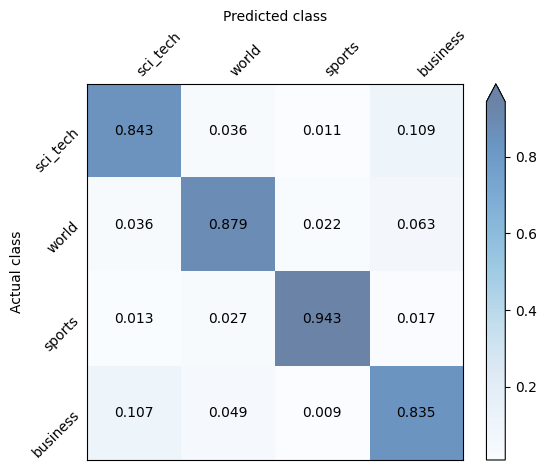

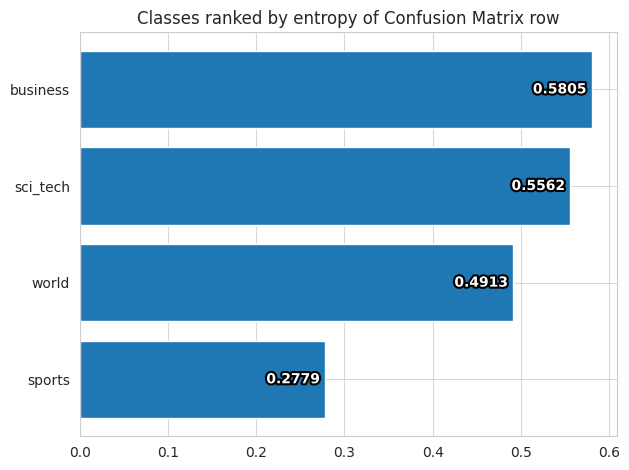

In [8]:
# Visualizes confusion matrix, which gives an overview of classifier performance
# for each class.
from ludwig.visualize import confusion_matrix

confusion_matrix(
  [test_stats],
  model.training_set_metadata,
  'class',
  top_n_classes=[5],
  model_names=[''],
  normalize=True,
)

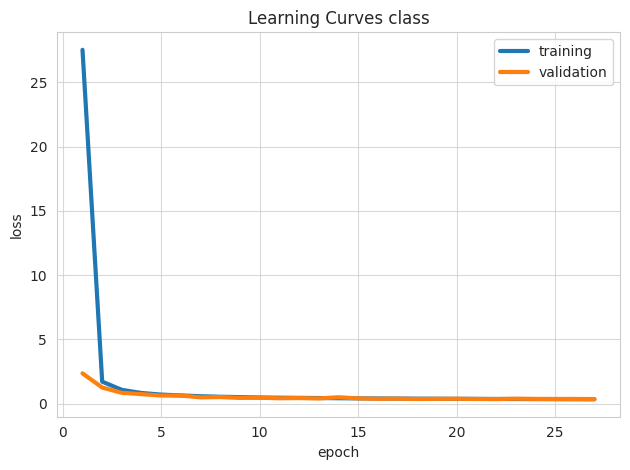

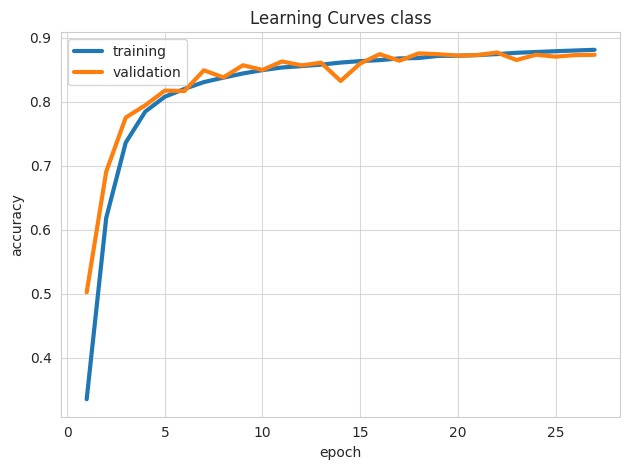

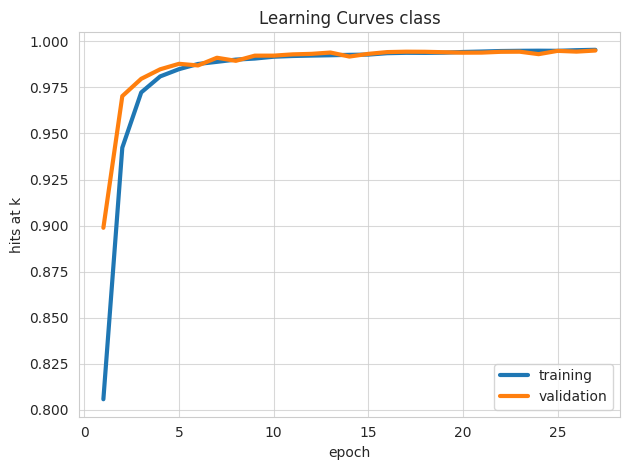

In [9]:
# Visualizes learning curves, which show how performance metrics changed over
# time during training.
from ludwig.visualize import learning_curves

learning_curves(train_stats, output_feature_name='class')

# Make Predictions on New Data

Generate predictions for new data.

The following are some recent news headlines. Feel free to edit or add your own strings to text_to_predict to see how the newly trained model classifies them.

In [10]:
import pandas as pd

text_to_predict = pd.DataFrame.from_records([
  {"title": "NBA Playoff Picture 2023: Kings Clinch; Lakers Play-In Lock as Mavs Keep Sliding?",
   "description": "After Wednesday night, the gap between the Western Conference's fourth and 12th seeds is just five games. Only 2.5 games sit between No. 7 and No. 12, meaning the smallest bump in the road could be enough to throw an entire playoff plan off-course.."},
  {"title": "Google may spur cloud cybersecurity M&A with $5.4B Mandiant buy",
   "description": "Google LLC's proposed acquisition of a cyber defense services provider may spur a further surge of M&A activity in the cloud cybersecurity sector."},
  {"title": "Europe struggles to meet mounting needs of Ukraine's fleeing millions",
   "description": "More than 3.5 million people have fled abroad from the war in Ukraine, United Nations data showed on Tuesday, leaving Eastern Europe scrambling to provide them with care, schools and jobs even as daily numbers crossing borders ease."},
])

predictions, output_directory = model.predict(text_to_predict)

predictions

INFO:ludwig.utils.tokenizers:Loaded TorchText implementation of distilbert-base-uncased tokenizer
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:ludwig.utils.batch_size_tuner:Tuning batch size...
INFO:ludwig.utils.batch_size_tuner:Batch size 2 is invalid, must be less than or equal to 20.0% dataset size (0 sam

Prediction: 100%|██████████| 1/1 [00:00<00:00, 939.16it/s]


,class_predictions,class_probabilities,class_probability,class_probabilities_sci_tech,class_probabilities_world,class_probabilities_sports,class_probabilities_business
0,sports,"[3.489922661970013e-08, 0.00010609512537484989...",0.999893,3.489923e-08,0.000106,9.998932e-01,7.291574e-07
1,sci_tech,"[0.9933932423591614, 3.21265215461608e-05, 3.3...",0.993393,9.933932e-01,0.000032,3.325229e-09,6.574597e-03
2,world,"[0.0012336561921983957, 0.9912399649620056, 1....",0.991240,1.233656e-03,0.991240,1.589930e-06,7.524781e-03


# Try other LLMs!

Ludwig supports training with a variety of LLMs from HF and torchtext. Read [these docs](https://ludwig.ai/latest/user_guide/distributed_training/finetuning/#features-supporting-fine-tuning) for a full list.



# Train a model on multiple GPUs

Very large LLMs require multiple GPUs to be stored in memory and trained. Here is how to do it in Ludwig by changing the configuration.

NOTE: This may not run successfully using free colab hardware. Consider predibase.com for a hosted solution.

In [ ]:
config = {
  "input_features": [
    {
      "name": "title",    # The name of the input column
      "type": "text",     # Data type of the input column
      "encoder": {
          "type": "auto_transformer",   # The model architecture to use
          "pretrained_model_name_or_path": "bigscience/bloom-3b",
          "trainable": True,
      },                           
    },
  ],
  "output_features": [
    {
      "name": "class",
      "type": "category",
    }
  ],
  "trainer": {
    "learning_rate": 0.00001,
    "epochs": 3,  # We'll train for three epochs. Training longer might give
                  # better performance.
  },
  "backend": {
    "type": "ray",
    "trainer": {
      "strategy": "fsdp", # fsdp distributed strategy for using a multi-GPU cluster
    }
  }
}